### 1) Data Preparing

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split

In [2]:
#기초 데이터 수립
(train_data, train_label), (holdout_data, holdout_label) = keras.datasets.cifar10.load_data()

In [3]:
%whos

Variable           Type        Data/Info
----------------------------------------
holdout_data       ndarray     10000x32x32x3: 30720000 elems, type `uint8`, 30720000 bytes (29.296875 Mb)
holdout_label      ndarray     10000x1: 10000 elems, type `uint8`, 10000 bytes
keras              module      <module 'tensorflow.keras<...>low\\keras\\__init__.py'>
np                 module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pd                 module      <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
tf                 module      <module 'tensorflow' from<...>tensorflow\\__init__.py'>
train_data         ndarray     50000x32x32x3: 153600000 elems, type `uint8`, 153600000 bytes (146.484375 Mb)
train_label        ndarray     50000x1: 50000 elems, type `uint8`, 50000 bytes
train_test_split   function    <function train_test_split at 0x0000013D67E8F1F0>


In [4]:
train_set, valid_set, train_label, valid_label = train_test_split(train_data, train_label, test_size = 0.3)

In [5]:
%whos

Variable           Type        Data/Info
----------------------------------------
holdout_data       ndarray     10000x32x32x3: 30720000 elems, type `uint8`, 30720000 bytes (29.296875 Mb)
holdout_label      ndarray     10000x1: 10000 elems, type `uint8`, 10000 bytes
keras              module      <module 'tensorflow.keras<...>low\\keras\\__init__.py'>
np                 module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pd                 module      <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
tf                 module      <module 'tensorflow' from<...>tensorflow\\__init__.py'>
train_data         ndarray     50000x32x32x3: 153600000 elems, type `uint8`, 153600000 bytes (146.484375 Mb)
train_label        ndarray     35000x1: 35000 elems, type `uint8`, 35000 bytes
train_set          ndarray     35000x32x32x3: 107520000 elems, type `uint8`, 107520000 bytes (102.5390625 Mb)
train_test_split   function    <function train_test_split at 0x0000013D67E8F1F0>
valid_

### a) 100개의 뉴런과 은닉층 20개로 심층 신경망 구축

In [24]:
np.random.seed(1234)

#모형 만들기
model1 = keras.models.Sequential()

#입력층 추가
model1.add(keras.layers.Flatten(input_shape = [32,32,3]))

#은닉층 추가
for i in range(20) : 
    model1.add(keras.layers.Dense(units = 100, activation = 'elu', kernel_initializer = 'he_normal'))
    

### b) Nadam 옵티마이저와 조기 종료를 사용하여 데이터를 훈련하세요. 모델 구조와 하이퍼파라미터를 바꿀때마다 적절한 학습률을 찾아야합니다.

Bayesian으로 학습률을 찾아볼 필요도 있다

In [34]:
import kerastuner as kt

def model_builder(hp, input_shape = [32,32,3]):
    
    #Sequential API
    model1 = keras.Sequential()
    
    #입력층 - 우리의 데이터에 맞게 넣는다.
    model1.add(keras.layers.Flatten(input_shape= input_shape))

  ##은닉층 추가
    for _ in range(20) : 
        model1.add(keras.layers.Dense(units = 100, activation = 'elu', kernel_initializer = 'he_normal'))
        
    #출력층 추가
    model1.add(keras.layers.Dense(units = 10, activation = 'softmax'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    model1.compile(optimizer = keras.optimizers.Nadam(learning_rate = hp_learning_rate,
                                                    beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'), loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

    return model1

np.random.seed(1234)

#베이지안으로 설정 후
tuner_bayes = kt.BayesianOptimization(hypermodel = model_builder, objective = 'val_loss', max_trials = 10, 
                                      project_name='practice',  directory = 'keras_parameter_dir')

#최적의 학습률 탐색 
tuner_bayes.search(train_set, train_label, epochs = 10, 
             validation_data = (valid_set, valid_label))


#최적의 파라미터는?
best_hps_bayes = tuner_bayes.get_best_hyperparameters(num_trials = 1)[0]
print("learning_rate : {0}".format(best_hps_bayes.get('learning_rate')) )

Trial 1 Complete [00h 01m 03s]
val_loss: 1.869254469871521

Best val_loss So Far: 1.6460872888565063
Total elapsed time: 00h 01m 03s
INFO:tensorflow:Oracle triggered exit
learning_rate : 0.0001


Epoch 1/100
1094/1094 [==============================] - 15s 11ms/step - loss: 10.5454 - accuracy: 0.1426 - val_loss: 2.1071 - val_accuracy: 0.2340
Epoch 2/100
1094/1094 [==============================] - 12s 11ms/step - loss: 2.0801 - accuracy: 0.2350 - val_loss: 1.9605 - val_accuracy: 0.2807
Epoch 3/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.9627 - accuracy: 0.2806 - val_loss: 1.8839 - val_accuracy: 0.3093
Epoch 4/100
1094/1094 [==============================] - 11s 11ms/step - loss: 1.8873 - accuracy: 0.3076 - val_loss: 1.8731 - val_accuracy: 0.3091
Epoch 5/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.8254 - accuracy: 0.3386 - val_loss: 1.8386 - val_accuracy: 0.3359
Epoch 6/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.7808 - accuracy: 0.3540 - val_loss: 1.7808 - val_accuracy: 0.3540
Epoch 7/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.7350 - accuracy: 0.3703 - val_loss: 

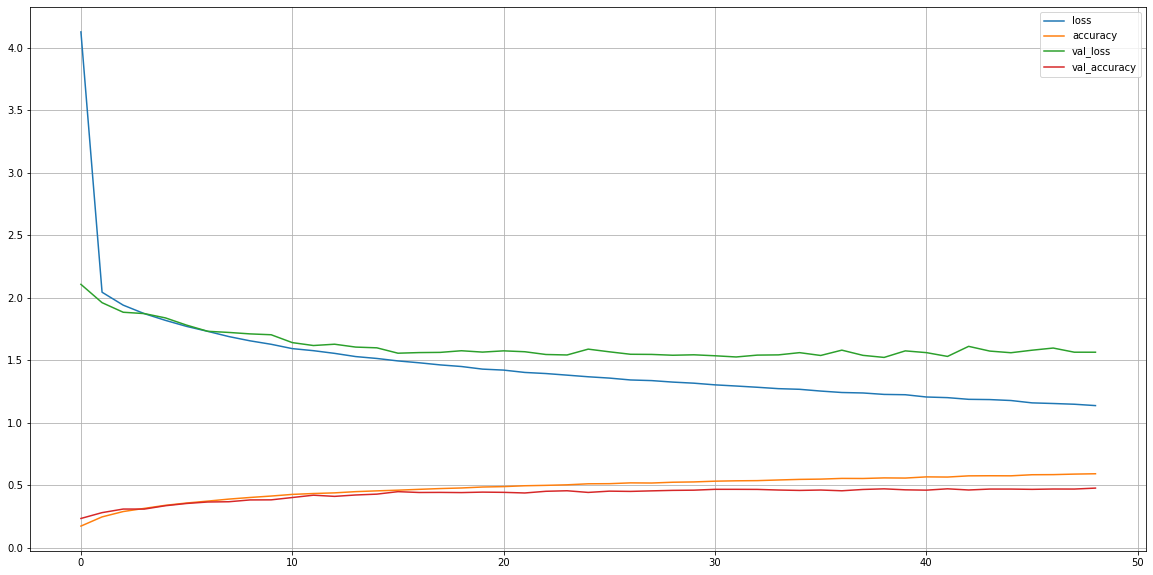

In [38]:
from sklearn import metrics

#early stopping rounds 설정
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

#최적의 파라미터를 가지고 모형을 전체 재적합!
np.random.seed(1234)
model_1 = tuner_bayes.hypermodel.build(best_hps_bayes)
history_1  = model_1.fit(train_set, train_label, epochs = 100, validation_data = (valid_set, valid_label), verbose = 1,
           callbacks = [early_stopping_cb])

import matplotlib.pyplot as plt
#학습 그래프 생성
pd.DataFrame(history_1.history).plot(figsize = (20,10))
plt.grid(True)
plt.show()

In [53]:
#validation에 대한 성과
pd.DataFrame(history_1.history)[-1:]

,loss,accuracy,val_loss,val_accuracy
48,1.137017,0.591686,1.564107,0.476933


### c) 배치 정규화를 추가하고 학습 곡선을 비교하라 - 이전보다 더 빠르게 수렴하는지, 더 좋은 모델이 만들어지는지, 훈련 속도에 영향을 미치는 지?

Trial 10 Complete [00h 02m 09s]
val_loss: 1.701399564743042

Best val_loss So Far: 1.6613517999649048
Total elapsed time: 00h 21m 09s
INFO:tensorflow:Oracle triggered exit
learning_rate : 0.0001
Epoch 1/100
1094/1094 [==============================] - 16s 12ms/step - loss: 18.1444 - accuracy: 0.1385 - val_loss: 2.1380 - val_accuracy: 0.2207
Epoch 2/100
1094/1094 [==============================] - 13s 12ms/step - loss: 2.0560 - accuracy: 0.2504 - val_loss: 1.9539 - val_accuracy: 0.2851
Epoch 3/100
1094/1094 [==============================] - 13s 12ms/step - loss: 1.9425 - accuracy: 0.2886 - val_loss: 1.9090 - val_accuracy: 0.3005
Epoch 4/100
1094/1094 [==============================] - 13s 12ms/step - loss: 1.8727 - accuracy: 0.3156 - val_loss: 1.8480 - val_accuracy: 0.3283
Epoch 5/100
1094/1094 [==============================] - 13s 12ms/step - loss: 1.8144 - accuracy: 0.3401 - val_loss: 1.8467 - val_accuracy: 0.3267
Epoch 6/100
1094/1094 [==============================] - 13s 12ms/ste

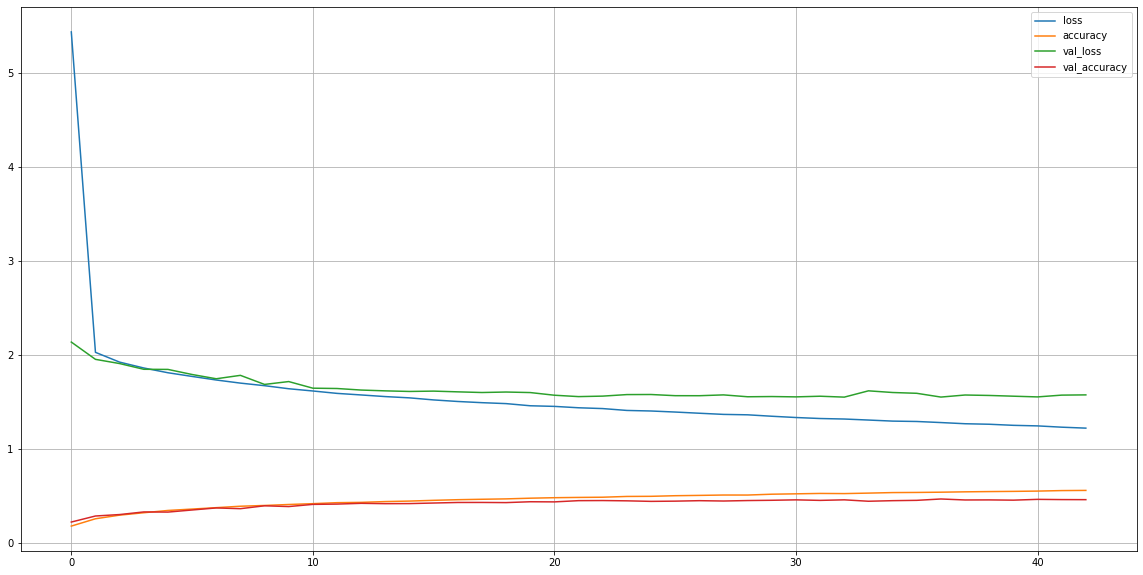

        loss  accuracy  val_loss  val_accuracy
42  1.221144  0.557686   1.57534      0.459133


In [54]:
import kerastuner as kt

def model_builder_batch(hp, input_shape = [32,32,3]):
    
    #Sequential API
    model = keras.Sequential()
    
    #입력층 - 우리의 데이터에 맞게 넣는다.
    model.add(keras.layers.Flatten(input_shape= input_shape))
    model.add(keras.layers.BatchNormalization())
  ##은닉층 추가
    for _ in range(20) : 
        model.add(keras.layers.Dense(units = 100, activation = 'elu', kernel_initializer = 'he_normal'))
        model.add(model.add(keras.layers.BatchNormalization()))
        
    #출력층 추가
    model.add(keras.layers.Dense(units = 10, activation = 'softmax'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Nadam(learning_rate = hp_learning_rate,
                                                    beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'), loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

    return model

np.random.seed(1234)

#베이지안으로 설정 후
tuner_bayes_batch = kt.BayesianOptimization(hypermodel = model_builder, objective = 'val_loss', max_trials = 10, 
                                      project_name='practice_batch',  directory = 'keras_parameter_dir')

#최적의 학습률 탐색 
tuner_bayes_batch.search(train_set, train_label, epochs = 10, 
             validation_data = (valid_set, valid_label))


#최적의 파라미터는?
best_hps_bayes_batch = tuner_bayes_batch.get_best_hyperparameters(num_trials = 1)[0]
print("learning_rate : {0}".format(best_hps_bayes_batch.get('learning_rate')) )

from sklearn import metrics

#early stopping rounds 설정
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

#최적의 파라미터를 가지고 모형을 전체 재적합!
np.random.seed(1234)
model_2 = tuner_bayes_batch.hypermodel.build(best_hps_bayes_batch)
history_2  = model_2.fit(train_set, train_label, epochs = 100, validation_data = (valid_set, valid_label), verbose = 1,
           callbacks = [early_stopping_cb])

import matplotlib.pyplot as plt
#학습 그래프 생성
pd.DataFrame(history_2.history).plot(figsize = (20,10))
plt.grid(True)
plt.show()

#validation에 대한 성과
print(pd.DataFrame(history_2.history)[-1:])

> 모형이 수렴하는 속도는 더 빨라졌지만 성능은 더 좋지 않게 나오는 듯 싶다

### d) 배치정규화를 SELU로 교체. 자기 정규화 하기 위해 필요한 변경사항을 적용해보라

(입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층신경망)

In [61]:
import kerastuner as kt
import tensorflow as tf
from tensorflow import keras


#모델 구축
model_snn = keras.Sequential()

#입력층
model_snn.add(keras.layers.Flatten(input_shape= [32,32,3]))

#은닉층 추가(20개)
for _ in range(20) : 
    model_snn.add(keras.layers.Dense(units = 100, activation = 'selu', kernel_initializer = 'lecun_normal',bias_initializer='zeros'))
        
#출력층 추가
model_snn.add(keras.layers.Dense(units = 10, activation = 'softmax'))

#model compile
model_snn.compile(optimizer = keras.optimizers.Nadam(learning_rate = 0.0001,
                                                     beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'), loss = 'SparseCategoricalCrossentropy', metrics = ['accuracy'])

#early stopping rounds 설정
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

#모형 학습 
np.random.seed(1234)

history_snn  = model_snn.fit(train_set, train_label, epochs = 100, validation_data = (valid_set, valid_label), verbose = 1,
           callbacks = [early_stopping_cb])

import matplotlib.pyplot as plt
#학습 그래프 생성
pd.DataFrame(history_snn.history).plot(figsize = (20,10))
plt.grid(True)
plt.show()

#validation에 대한 성과
print(pd.DataFrame(history_snn.history)[-1:])

Epoch 1/100
1094/1094 [==============================] - 15s 11ms/step - loss: 2.1320 - accuracy: 0.2190 - val_loss: 1.9114 - val_accuracy: 0.2951
Epoch 2/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.8294 - accuracy: 0.3280 - val_loss: 1.8079 - val_accuracy: 0.3426
Epoch 3/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.7520 - accuracy: 0.3634 - val_loss: 1.7535 - val_accuracy: 0.3541
Epoch 4/100
1094/1094 [==============================] - 11s 10ms/step - loss: 1.6914 - accuracy: 0.3901 - val_loss: 1.6909 - val_accuracy: 0.3923
Epoch 5/100
1094/1094 [==============================] - 11s 10ms/step - loss: 1.6551 - accuracy: 0.4041 - val_loss: 1.6660 - val_accuracy: 0.3969
Epoch 6/100
1094/1094 [==============================] - 11s 10ms/step - loss: 1.6093 - accuracy: 0.4197 - val_loss: 1.6441 - val_accuracy: 0.4084
Epoch 7/100
1094/1094 [==============================] - 11s 10ms/step - loss: 1.5722 - accuracy: 0.4344 - val_loss: 1

KeyboardInterrupt: 

(드롭아웃을 먹였더니 성능이 아주 안 좋게 나왔다)